In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import pickle
import networkx as nx
from matplotlib import cm
import matplotlib.pyplot as plt
import ast 


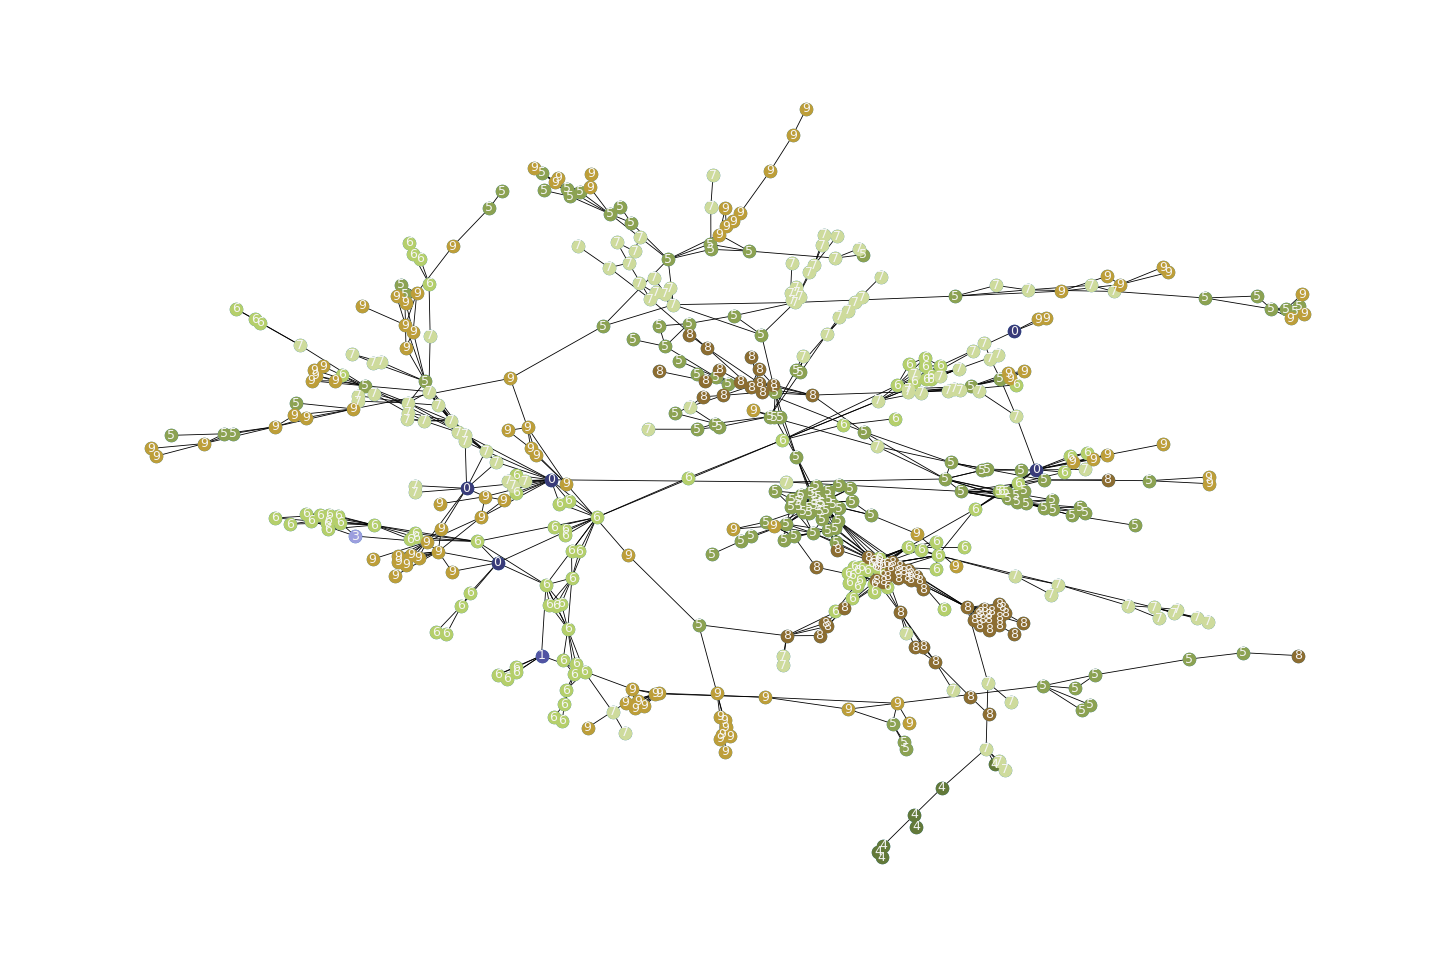

In [2]:
# Load metadata for plot into pandas df - assume can load into RAM
meta_df = pd.read_csv("../tests/data/scopus/col_au_name_lookup")

with open("../results/scopus_Z.pkl", "rb") as f:
    Z = pickle.load(f)
with open("../tests/data/scopus/col_A.pkl", "rb") as f:
    A = pickle.load(f)

G = nx.from_numpy_array(A[-1])
pos = nx.spring_layout(G)
fig, ax = plt.subplots(dpi=300)
node_size = 5
nx.draw(G, pos, edge_color="k", node_size=node_size, width=0.2, ax=ax)
cmap = cm.get_cmap("tab20b")
# For each community list, draw the nodes, giving it a specific color.
labels = {}
for block in np.unique(Z[:, -1]):
    color = [cmap(block)]
    tmp_nodes = np.nonzero(Z[:, -1] == block)[0]
    labels.update({node: block for node in tmp_nodes})
    nx.draw_networkx_nodes(
        G, pos, nodelist=tmp_nodes, node_size=node_size, node_color=color,
    )
show_labels = True
if show_labels:
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_color="whitesmoke")
fig.savefig("../results/scopus_colAv1.png", bbox_inches="tight")
plt.show()


In [3]:
# add block info to df 
meta_df = meta_df.set_index('index').sort_index()
meta_df["block"] = Z[:, -1]

In [56]:
net_df = pd.DataFrame(pos).T.rename(columns={0: "x_pos", 1: "y_pos"})
fig = go.FigureWidget()
add_edges = True 
if add_edges:
    # make path over all edges
    euler_path = nx.eulerian_circuit(nx.eulerize(G))
    # get first point
    path_points = next(euler_path)
    path_points = [[pos[path_points[0]][0]], [pos[path_points[0]][1]]]
    # now rest of path is just target elem of edges in path 
    for _,target in euler_path: 
        path_points[0].append(pos[target][0])
        path_points[1].append(pos[target][1])
    fig.add_trace(go.Scatter(x=path_points[0], y=path_points[1], mode="lines",line=dict(color='lightgray', width=0.3),showlegend=False))
    # naive way
    # for edge in np.array(np.nonzero(A[-1])).T:
    #     fig.add_trace(
    #         go.Scatter(
    #             x=[pos[edge[0]][0], pos[edge[1]][0]],
    #             y=[pos[edge[0]][1], pos[edge[1]][1]],
    #             hoverinfo=None,
    #             line=dict(color="black", width=0.5),
    #             # marker=None,
    #             mode="lines",
    #             showlegend=False,
    #         )
    #     )
fig.add_trace(
    go.Scatter(x=net_df.x_pos, y=net_df.y_pos, mode="markers", text=meta_df["au_name"],name="Authors",
               marker=dict(color=meta_df['block']))
)
fig.update_xaxes(showgrid=False, zeroline=False,showticklabels=False)
fig.update_yaxes(showgrid=False, zeroline=False,showticklabels=False)
fig.update_layout(plot_bgcolor='#ffffff')
# # Add net plot as image
# fig.add_layout_image(
#         dict(
#             source="../results/scopus_colAv1.png",
#             # xref="x_pos",
#             # yref="y_pos",
#             x=0,
#             y=1,
#             sizex=1,
#             sizey=1,
#             # sizing="stretch",
#             opacity=0.5,
#             layer="below")
# )


FigureWidget({
    'data': [{'line': {'color': 'lightgray', 'width': 0.3},
              'mode': 'lines',
    …

In [57]:
scatter = fig.data[-1]
# def fn that inputs opacity and size and updates figure 
def set_opacity(opacity, size):
    scatter.marker.opacity = opacity
    scatter.marker.size = size
# and generate control panel for fn 
from ipywidgets import interactive
opacity_slider = interactive(set_opacity,
                             opacity=(0.0, 1.0, 0.01),
                             size=(1, 10, 0.25))
# then adjust length of widgets 
opacity_slider.children[0].layout.width = '400px'
opacity_slider.children[1].layout.width = '400px'

In [58]:
if type(meta_df['subj_props'].iloc[0])==str:
    for attrb in ["subj","ctry"]: 
        meta_df[f"{attrb}_props"] = meta_df[f"{attrb}_props"].apply(ast.literal_eval) 
        meta_df[f"{attrb}_props"] = meta_df[f"{attrb}_props"].apply(lambda x: [(attrb,np.round_(val,3)) for attrb,val in x])


In [59]:
# create html widget to display hover props
from ipywidgets import HTML

details = HTML()

# create image widget to display image
from ipywidgets import Image, Layout

subj_data = {}
for block in np.unique(Z[:,-1]): 
    if block!=-1:
        with open(f"../results/scopus_colAv1_subjareas_block{block}.png", "rb") as f:
            b = f.read()
        subj_data[block] = b

ctry_data = {}
for block in np.unique(Z[:,-1]): 
    with open(f"../results/scopus_colAv1_ctrys_block{block}.png", "rb") as f:
        b = f.read()
    ctry_data[block] = b

subj_widget = Image(
    value=subj_data[block],
    layout=Layout(height="252px", width="400px"),
)
ctry_widget = Image(
    value=ctry_data[block],
    layout=Layout(height="252px", width="400px"),
)

# register callback function for update on hover events
# update image widget along w html widget
def hover_fn(trace, points, state):

    ind = points.point_inds[0]

    # Update details HTML widget
    df_loc = meta_df.iloc[ind]
    cols = ['au_name','subj_props','ctry_props']
    details.value = df_loc[cols].to_frame().to_html()

    # Update image widget
    block = meta_df["block"][ind]
    subj_widget.value = subj_data[block]
    ctry_widget.value = ctry_data[block]


scatter.on_hover(hover_fn)

# create simple dashboard w hbox and vbox containers
from ipywidgets import HBox, VBox

VBox([fig, opacity_slider, 
      HBox([subj_widget, ctry_widget]),
      details
      ])




    'data': [{'line': {'color': 'lightgray', 'width': 0.3},
              'mode'…